In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [2]:
from tensorflow.keras.applications import VGG19

network = VGG19(include_top=False,weights="imagenet")

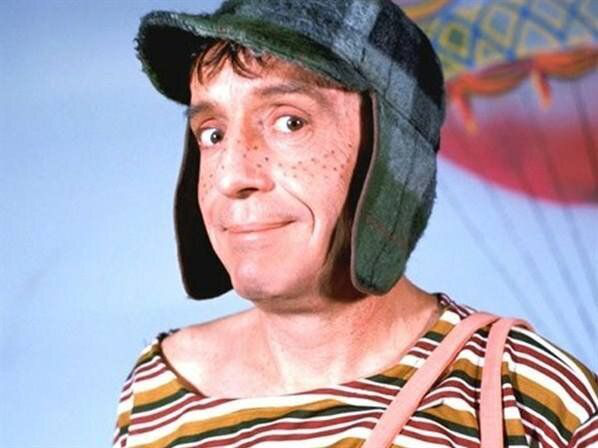

In [3]:
from tensorflow.keras.preprocessing.image import load_img

content_image = load_img("../Images/chaves.jpeg")
content_image

In [4]:
content_image = tf.keras.preprocessing.image.img_to_array(content_image)
content_image = content_image/255
content_image = content_image[tf.newaxis,:]

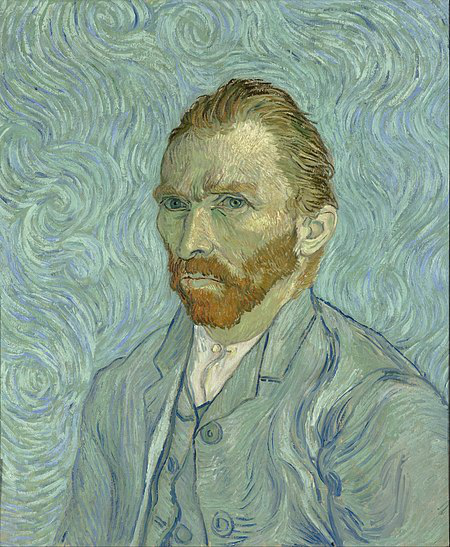

In [5]:
style_image = load_img("../Images/vangogh.jpg")
style_image

In [6]:
style_image = tf.keras.preprocessing.image.img_to_array(style_image)
style_image = style_image/255
style_image = style_image[tf.newaxis,:]

In [7]:
content_layers = ["block4_conv2"]
style_layers = [f"block{i}_conv1" for i in range(1,6)]
num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [8]:
from tensorflow.keras import Model

def vgg_layers(layer_names):
    vgg = VGG19(include_top=False,weights="imagenet")
    vgg.trainable = False
    
    outputs = [vgg.get_layer(name).output for name in layer_names]
    network = Model(inputs=[vgg.input],outputs=outputs)
    return network

In [9]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image)

In [10]:
def gram_matrix(layer_activation):
    result = tf.linalg.einsum("bijc,bijd->bcd",
                              layer_activation,
                              layer_activation)
    input_shape = tf.shape(layer_activation)
    num_locations = tf.cast(input_shape[1]*input_shape[2],tf.float32)
    return result/num_locations

In [11]:
class StyleContentModel(Model):
    def __init__(self,style_layers,content_layers):
        super().__init__()
        self.vgg = vgg_layers(style_layers+content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False
    
    def call(self,inputs):
        inputs = inputs*255.0
        preprocess_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocess_input)
        style_outputs = outputs[:self.num_style_layers]
        content_outputs = outputs[self.num_style_layers:]
        
        style_outputs = [gram_matrix(style_output) for style_output in style_outputs]
        
        content_dict = {content_name:value for content_name,value in zip(self.content_layers,content_outputs)}
        style_dict = {style_name:value for style_name,value in zip(self.style_layers,style_outputs)}
        
        return {"content":content_dict,"style":style_dict}

In [12]:
extractor = StyleContentModel(style_layers,content_layers)
results = extractor(content_image)

In [13]:
style_targets = extractor(style_image)["style"]
content_targets = extractor(content_image)["content"]

In [14]:
new_image = tf.Variable(content_image)

In [15]:
content_weight = 1
style_weight = 1000
optimizer = tf.optimizers.Adam(learning_rate=0.02)
epochs = 50
print_every = 10

Epoch 10, content loss: 318649.1875, style loss: 3867401216.0, total loss: 773480579072.0


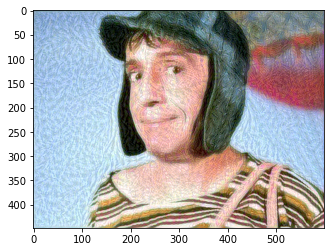

Epoch 20, content loss: 353242.03125, style loss: 1127994368.0, total loss: 225599225856.0


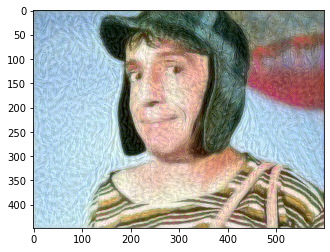

Epoch 30, content loss: 365908.46875, style loss: 510096064.0, total loss: 102019579904.0


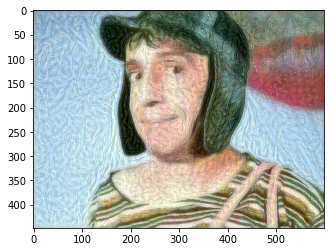

Epoch 40, content loss: 373636.0625, style loss: 300152480.0, total loss: 60030869504.0


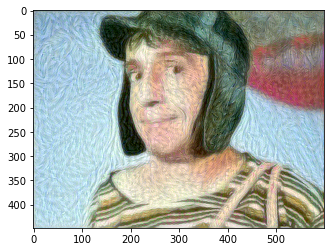

Epoch 50, content loss: 379040.1875, style loss: 206422912.0, total loss: 41284964352.0


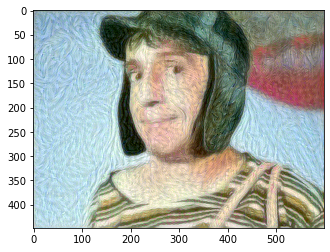

In [16]:
from sklearn.metrics import mean_absolute_error

for epoch in range(epochs):
    with tf.GradientTape() as tape:
        outputs = extractor(new_image)
        
        content_outputs = outputs["content"]
        style_outputs = outputs["style"]
        
        content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) for name in content_outputs.keys()])
        style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) for name in style_outputs.keys()])
        
        total_loss = content_loss * content_weight/num_content_layers + style_loss*style_weight/num_style_layers
    
    gradient = tape.gradient(total_loss,new_image)
    optimizer.apply_gradients([(gradient,new_image)])
    new_image.assign(tf.clip_by_value(new_image,0.0,1.0))
    if (epoch+1)%print_every==0:
        print(f"Epoch {epoch+1}, content loss: {content_loss}, style loss: {style_loss}, total loss: {total_loss}")
        plt.imshow(tf.squeeze(new_image,axis=0))
        plt.show()

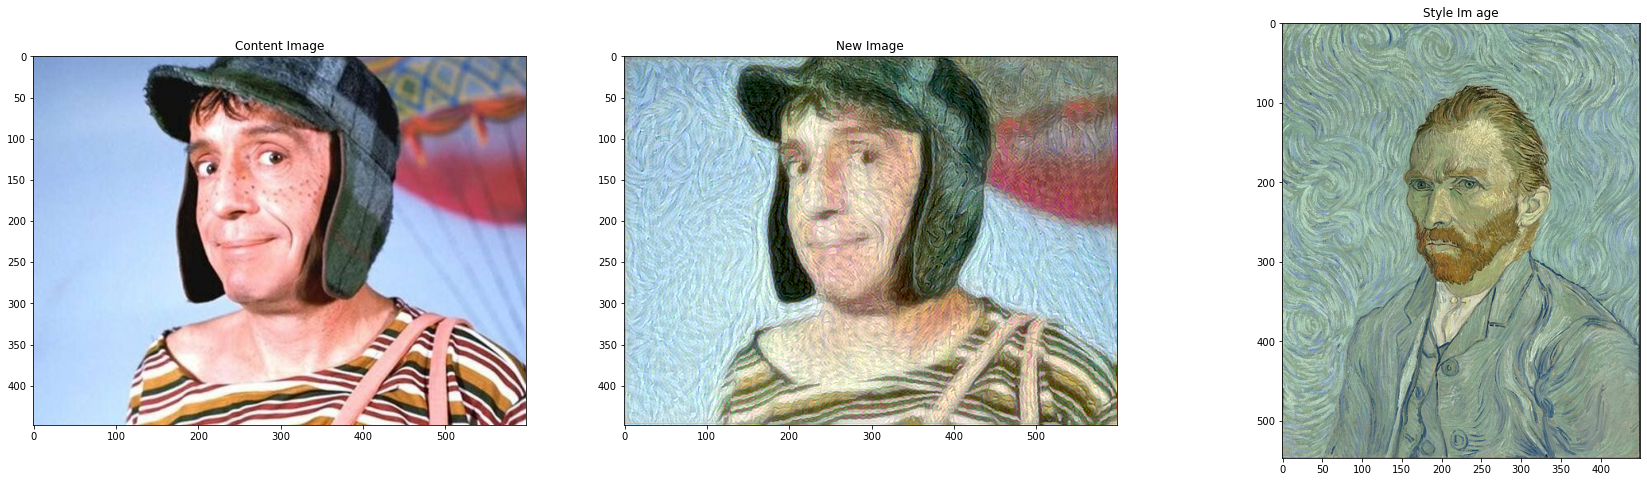

In [17]:
fig,axes = plt.subplots(1,3,figsize=(30,8))
axes.ravel()
axes[0].imshow(tf.squeeze(content_image,axis=0))
axes[0].set_title("Content Image")
axes[1].imshow(tf.squeeze(new_image,axis=0))
axes[1].set_title("New Image")
axes[2].imshow(tf.squeeze(style_image,axis=0))
axes[2].set_title("Style Im age")
plt.show()